## Import the MNIST dataset and split into train, val and test

In [1]:
import tensorflow as tf
from tensorflow import keras

fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [2]:
from tensorflow.keras.utils import to_categorical
import numpy as np

boundary = 50000
num_classes = 10

X_train = train_images[:boundary, :, :]
y_train = to_categorical(train_labels[:boundary], num_classes=num_classes)

X_val = train_images[boundary:, :, :]
y_val = to_categorical(train_labels[boundary:], num_classes=num_classes)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

print(X_train.dtype)
print(y_train.dtype)

print(y_train[0])

(50000, 28, 28)
(10000, 28, 28)
(50000, 10)
(10000, 10)
uint8
float32
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Shuffle the training data
### Use the Tensorflow dataset API

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


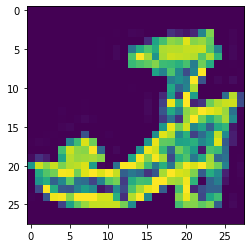

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

shuffle_seed = 47
buffer_size = 100

X_train_shuffled = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=buffer_size, 
                                                                       seed = shuffle_seed)
y_train_shuffled = tf.data.Dataset.from_tensor_slices(y_train).shuffle(buffer_size=buffer_size, 
                                                                       seed = shuffle_seed)

for image in X_train_shuffled.take(1):
    plt.imshow(image)
for label in y_train_shuffled.take(1):
    print(label.numpy())

## Save the data using TensorFlow protobufs and TFRecord files

### Serialize the image & label

In [11]:
def serialize_tensors(X):
    X_serial = []
    for x in X:
        X_serial.append(tf.io.serialize_tensor(tensor = x))
    return X_serial
    
###############################################

X_train_serial = serialize_tensors(X_train_shuffled)
X_val_serial = serialize_tensors(X_val)
y_train_serial = serialize_tensors(y_train_shuffled)
y_val_serial = serialize_tensors(y_val)

print('# of serialized train images = ', len(X_train_serial))
print('# of serialized train labels = ', len(y_train_serial))

print('# of serialized val images = ', len(X_val_serial))
print('# of serialized val labels = ', len(y_val_serial))

# of serialized train images =  50000
# of serialized train labels =  50000
# of serialized val images =  10000
# of serialized val labels =  10000


### Create the protobufs

In [12]:
from tensorflow.compat.v2.train import Feature, Features, Example, BytesList
import numpy as np

# Only the numpy array of the tensor is saved to file --> lose all other tensor info

def create_protobuf_X_and_y(X_serial, y_serial, X_shape, y_shape):

    X_as_bytes = []
    y_as_bytes = []
    X_shape_as_bytes = [] 
    y_shape_as_bytes = []
    for X, y in zip(X_serial, y_serial):
        X_as_bytes.append(BytesList(value=[X.numpy()])) # Convert image to bytes list
        y_as_bytes.append(BytesList(value=[y.numpy()])) # Convert label to bytes list
        X_shape_as_bytes.append(BytesList(value=[X_shape.numpy()]))
        y_shape_as_bytes.append(BytesList(value=[y_shape.numpy()]))
        
    protobuf_data = []
    for X, y, X_shape, y_shape in zip(X_as_bytes, y_as_bytes, X_shape_as_bytes, y_shape_as_bytes):
        protobuf_data.append(Example(
            features = Features(
                feature={
                    'X': Feature(bytes_list = X),
                    'y': Feature(bytes_list = y),
                    'X_shape': Feature(bytes_list = X_shape),
                    'y_shape': Feature(bytes_list = y_shape)
                }
            )
        ))
        
    return protobuf_data
X_shape = tf.io.serialize_tensor(tensor = [28, 28])
y_shape = tf.io.serialize_tensor(tensor = [10])

protobuf_data_train = create_protobuf_X_and_y(X_train_serial, 
                                              y_train_serial, 
                                              X_shape, 
                                              y_shape)

protobuf_data_val = create_protobuf_X_and_y(X_val_serial, 
                                              y_val_serial, 
                                              X_shape, 
                                              y_shape)

## Write the records to file

In [13]:
def write_tf_records(filename, data):
    with tf.io.TFRecordWriter(filename) as f:
        for d in data:
            f.write(d.SerializeToString())
            
write_tf_records('train.tfrecord', protobuf_data_train)
write_tf_records('val.tfrecord', protobuf_data_val)

## Read the records from file

In [15]:
def extract_fn(data_record):
    
    feature_description = {
    'X': tf.io.FixedLenFeature([], tf.string),
    'y': tf.io.FixedLenFeature([], tf.string),
    'X_shape': tf.io.FixedLenFeature([], tf.string),
    'y_shape': tf.io.FixedLenFeature([], tf.string)
    }
    
    return tf.io.parse_single_example(data_record, feature_description)

dataset_train = tf.data.TFRecordDataset(['train.tfrecord'])
dataset_train = dataset_train.map(extract_fn) # Strings of numpy data for x, y

dataset_val = tf.data.TFRecordDataset(['val.tfrecord'])
dataset_val = dataset_val.map(extract_fn) # Strings of numpy data for x, y

def create_image_label_pairs(data_record):
    
    X = tf.io.parse_tensor(data_record['X'], out_type=tf.uint8)
    y = tf.io.parse_tensor(data_record['y'], out_type=tf.float32)
    X_shape = tf.io.parse_tensor(data_record['X_shape'], out_type=tf.float32)
    y_shape = tf.io.parse_tensor(data_record['y_shape'], out_type=tf.float32)
    
    # TODO: Get the shapes out of the TFRecord so can use them here
    
    X.set_shape((28,28))
    y.set_shape((10))
    
    return (X, y)
        
dataset_train_tuple = dataset_train.map(create_image_label_pairs) # Create tuples of image, label tensors
dataset_val_tuple = dataset_val.map(create_image_label_pairs) # Create tuples of image, label tensors

## Train a model using Keras

In [16]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(30, activation='relu', kernel_initializer='glorot_uniform'),
    keras.layers.Dense(30, activation='relu', kernel_initializer='glorot_uniform'),
    keras.layers.Dense(10, activation='softmax')
])

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                23550     
_________________________________________________________________
dense_4 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                310       
Total params: 24,790
Trainable params: 24,790
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(dataset_train_tuple.batch(32), 
          validation_data=dataset_val_tuple.batch(32), 
          epochs=10)

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6102 - accuracy: 0.5346 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.9603 - accuracy: 0.6143 - val_loss: 0.8976 - val_accuracy: 0.6245
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.9219 - accuracy: 0.6229 - val_loss: 0.9193 - val_accuracy: 0.6186
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9025 - accuracy: 0.6294 - val_loss: 0.8696 - val_accuracy: 0.6303
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8796 - accuracy: 0.6382 - val_loss: 0.8231 - val_accuracy: 0.6616
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.7579 - accuracy: 0.7161 - val_loss: 0.6789 - val_accuracy: 0.7268
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.7143 - accuracy: 0.7259 - val_loss: 0.6708 - val_a